# How to calculate the longitudinal field and False Alarm Probability

The calculation of the longitudinal magnetic field ($B_{z}$) from a Stokes V line profile is done using:

$$B_{z} = \frac{-1}{g_\mathrm{eff} \ell_{\mathrm{const}} \lambda_o c}\frac{\int vV(v)dv}{\int (1-I(v))dv},$$

where $I(v)$ and $V(v)$ are the continuum normalized $I/I_c$ and $V/I_c$, $v$ is the velocity relative to the center of the line, and

$$\ell_{\mathrm{const}} = \frac{e}{4\pi m_e c^2} \approx 4.67\times 10^{-12} ~ \mathrm{nm}^{-1} \mathrm{G}^{-1}$$

When calculating $B_{z}$ from an LSD profile, the rest wavelength of the line ($\lambda_o$) and effective Landé factor ($g_\mathrm{eff}$) should be the normalizing values used in the LSD calculation.

Note that the <a href='../API/LSD_API.html#specpolFlow.LSD.calc_bz'>`calc_bz`</a> function of the <a href='../API/LSD_API.html#specpolFlow.LSD'>`LSD`</a> class presented here requires $\lambda_o$ to be given in nanometers.

The False Alarm Probability (FAP) of a signal in Stokes V and the null profile is also computed over the same velocity range used in the $B_z$ calculation. The FAP is the p-value for the probability that the observed Stokes V, or null, profile is consistent with just noise.  More specifically, it is the probability that a model consisting of a flat line is consistent with the observations, based on $\chi^2$.  When reporting a detection of a signal based on the FAP, typically:
* For a definitive detection, FAP < $10^{-4}$
* For a marginal detection, FAP < $10^{-2}$

Although different sources may use slightly different thresholds, it can be helpful to adopt more conservative criteria when dealing with large numbers of stars.

## 1. Example with one LSD profile

First import specpolFlow and any other packages

In [1]:
import specpolFlow as pol

import pandas as pd

In [2]:
# these import are just for the rendering of the notebook in html
# no need to show on the website
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
# myst_nb is only used for rendering a few numbers on the website, 
# and can be skipped entirely if it isn't installed
try:
    from myst_nb import glue
    use_myst_nb = True
except:
    use_myst_nb = False

We load an example LSD profile ([SampleLSD.lsd](https://github.com/folsomcp/specpolFlow/blob/main/docs-jb/Tutorials/CalculateBz_tutorialfiles/SampleLSD.lsd)) and use the built-in plotting routine to visualize the Stokes V, null, and I profiles.

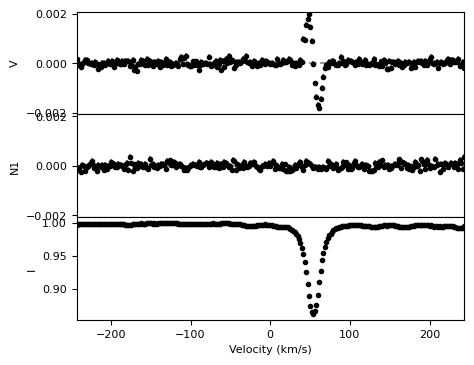

In [3]:
lsd = pol.read_lsd('CalculateBz_tutorialfiles/SampleLSD.lsd')
fig, ax = lsd.plot(figsize=(5,4))

To calculate Bz, we call the <a href='../API/LSD_API.html#specpolFlow.LSD.calc_bz'>`calc_bz`</a> function of the LSD object. The result is returned as a Python dictionary.  

When using <a href='../API/LSD_API.html#specpolFlow.LSD.calc_bz'>`calc_bz`</a> you must provide the effective Landé factor (`geff`) and rest wavelength (`lambda0`) for the calculation. In general, these should be the normalizing values used for calculating the LSD profile.

:::{Note} 
In LSD profiles that do not have a Null2 column, the LSD class replaces N2 with zeros, which means that the N2 Bz will also be set to zero.
:::

### 1.1 Using the auto-normalization and auto-cog calculations

In this example, we will use the automatic methods to renormalize the continuum of the LSD profile from the Stokes I (`norm='auto'`) and compute the center of the line (the 'center-of-gravity' or cog) by using Stokes I only (`cog='I'`). 

To do so, we set the `velrange` option to [0.0, 100].0:
* The data *inside* of this velocity range is used to calculate the center-of-gravity (cog) of the profile
* The data *outside* of this velocity range is used to calculate the continuum level.

If we had not set the `velrange` keyword, the full range would have been be used for both calculations, although this usually produces less accurate results.  

There are a few options for alternative ways of calculating the cog, in the <a href='../API/LSD_API.html#specpolFlow.LSD.calc_bz'>calc_bz</a> docs.

We also set the `bzwidth` keyword to specify the velocity range *around the cog* (i.e. relative to the line center) that will then be used to compute $B_z$. 
:::{Note}
The `bzwidth` can be set to a single float (for example, `bzwidth=25.0` mean 25 km s$^{-1}$ on each side of the cog). The `bzwidth` can also be set to a 2-item tuple or array (for example, `bzwidth=(10.0, 25.0)` mean 10 km s$^{-1}$ on the blue side of the cog and 25 km s$^{-1}$ on the red side of the cog). Usually the integration range in the $B_z$ calculation should be symmetric about the line center, so `bzwidth` should usually be a single value.
:::
If `bzwidth` is not defined, then the `velrange` is used to compute $B_z$, which can be useful for specifying velocities in absolute units rather than relative to line center. (If both `bzwidth` and `velrange` are not defined, then the whole range is used - _but avoid this_!). 

Combining these options and using `plot=True` to generate a figure gives us:

using AUTO method for the normalization
  using the median of the continuum outside of the line


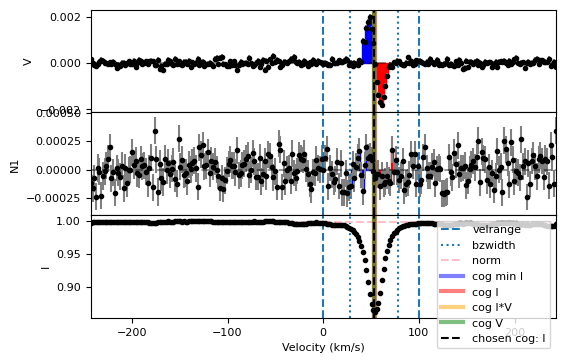

In [4]:
Bz, fig = lsd.calc_bz(cog='I', norm='auto', 
                      geff=1.2, lambda0=500.0,
                      velrange=[0.0, 100.0], bzwidth=25.0, 
                      plot=True, figsize=(6,4))

::::{margin}
:::{Note}
Because the option `plot` was set to True, the call to <a href='../API/LSD_API.html#specpolFlow.LSD.calc_bz'>`calc_bz` </a> returned both the dictionary of results and the matplotlib figure object. We have unpack these two returned quantities into two separate variables. 
:::
::::

The diagnostic figure above shows a few useful things:
- The dashed vertical lines show the values of `velrange`. 
- The dotted vertical lines show the values of `bzwidth`. 
- The dashed horizontal line shows the value of the continuum level (`Ic` in the legend)
- The code always computes *all* of the automatic options for the cog. They are indicated by the vertical thick solid lines with the colors indicated by the legend. 
- The cog that you have selected (one of the automatic values or a user-defined value as discussed below) is shown in dashed black vertical line. 
- As you can see in the equation, $B_z$ is related to the area under the curve of "Stokes V multiplied by ($v-\mathrm{cog}$)". In the graph, we show the area under the curve Stokes V *only* on each side of the cog. Note that this is only a guide.

The results are returned as a dictionary. 
You can see the results by printing it and accessing any value by its keyword:

In [5]:
print(Bz)
print('Bz = ', Bz["V bz (G)"], '+/-', Bz["V bz sig (G)"])

{'V bz (G)': 94.17678426512535, 'V bz sig (G)': 6.2520241712455595, 'V FAP': 0.0, 'N1 bz (G)': 4.858516305698941, 'N1 bz sig (G)': 6.122939627225724, 'N1 FAP': 0.76106309449015, 'N2 bz (G)': 0.0, 'N2 bz sig (G)': 0.0, 'N2 FAP': 0.0, 'norm_method': 'auto', 'norm': 0.99703, 'cog_method': 'I', 'cog': 53.3592394550717, 'int. range start': 28.3592394550717, 'int. range end': 78.3592394550717}
Bz =  94.17678426512535 +/- 6.2520241712455595


:::{tip}
The dictionary returned by `calc_bz` can be directly converted to a Pandas dataframe.  This can be convenient for saving or displaying results. 
:::

In [6]:
pd.DataFrame(data=[Bz]).style

,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP,norm_method,norm,cog_method,cog,int. range start,int. range end
0,94.176784,6.252024,0.000000,4.858516,6.122940,0.761063,0.000000,0.000000,0.000000,auto,0.997030,I,53.359239,28.359239,78.359239


In [7]:
# This cell of code is just to glue some numbers to use in the markdown cells 
# describing the results below.  Therefore it is hidden in the html rendering.
# If myst_nb isn't installed this can be safely skipped.
if use_myst_nb:
    glue("cog_glue", Bz['cog'])
    glue("min_glue", Bz['int. range start'])
    glue("max_glue", Bz['int. range end'])

53.3592394550717

28.3592394550717

78.3592394550717

The function reports $B_z$, the uncertainty on $B_z$, and the FAP, calculated with Stokes V (`V bz (G)`, `V bz sig (G)`, `V FAP`), and then the same quantities calculated using the nulls in place of Stokes V (`N1` and `N2`).

The function reports the computed values for the continuum level (`norm`) and the center of gravity value (`cog`).  It also returns the exact bounds that were used for the computation of $B_z$ and FAP. For example, here, we set `Bzwidth` to be 25 km s$^{-1}$ on each side of the cog, and the computed cog was {glue:text}`cog_glue:.2f` km s$^{-1}$. Therefore, 25 km s$^{-1}$ on each side of this cog will correspond to a velocity range of {glue:text}`min_glue:.2f` km s$^{-1}$ to {glue:text}`max_glue:.2f` km s$^{-1}$.

### 1.2 Using user-defined normalization and cog

In the previous example, we used automatic methods to calculate the continuum normalization and the cog. 

In some circumstances, you might not want to use the automatic methods. Perhaps you have already calculated your cog and your normalization. Perhaps you are trying to reproduce someone else's results. Perhaps the line shape is complicated, and the automatic methods do not give a good result. 

In this, we can simply set `cog=float` and `norm=float`. 

::::{margin}
:::{tip}
If you do not want the continuum normalization to be performed, simply set `norm=1.0`.
:::
::::

For example below, let's say that we have already computed $v_\mathrm{rad}$ and know that the continuum should be at 0.99. 

We will add one little thing: let's say you have already measured the line broadening and would like the $B_z$ computation to be done in a range corresponding to $1.5\times v\sin i$. 

using given norm value


,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP,norm_method,norm,cog_method,cog,int. range start,int. range end
0,110.831819,6.014489,0.000000,7.256635,5.880429,0.722025,0.000000,0.000000,0.000000,0.990000,0.990000,55.000000,55.000000,32.500000,77.500000


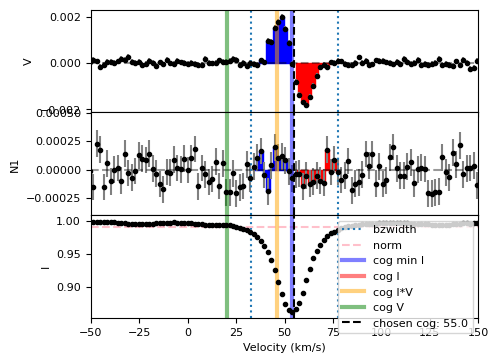

In [8]:
# Bz calculation using manual cog selection
vsini = 15.0
vrad = 55.0
Ic=0.99

lsd = pol.read_lsd('CalculateBz_tutorialfiles/SampleLSD.lsd')

Bz, fig = lsd.calc_bz(cog=vrad, bzwidth=1.5*vsini, norm=Ic,
                      plot=True, figsize=(5,4))

for item in fig.get_axes():
    item.set_xlim(-50,150)

pd.DataFrame(data=[Bz]).style

As you can see, the label in the legend for the dashed vertical black line now reflects the value of the cog that was specified. 

Also, you will note that we did not define a `velrange`. This was uncesesary, as we are not using the automated methods for neither the cog nor the continuum normalization. 

This said, if you would like to see how your choice for cog compares with the automated methods (which are always displayed in the diagnostic plot), then you could set an additional `velrange`. In the example below, we set it to be $2\times v\sin i$ on each side of our pre-computed radial velocity. 

using given norm value


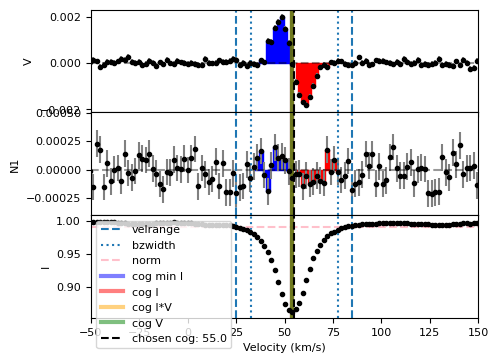

In [9]:
Bz, fig = lsd.calc_bz(cog = vrad, bzwidth = 1.5*vsini, norm=Ic,
                      velrange=[vrad-2*vsini, vrad+2*vsini],
                      plot = True, figsize=(5,4))

for item in fig.get_axes():
    item.set_xlim(-50,150)

## 2. Calculating Bz for multiple LSD profiles. 

When processing multiple LSD profiles, particularly multiple observations of the same star, it can be efficient to loop over a list of LSD profiles.  Then Bz can be calculated for each profile, by calling `calc_bz` inside the loop. In this example we consider LSD profiles from two different stars. We compute Bz and save the results for each observation into a list, converting the list of dictionaries into Pandas dataframe. Then, we add a column to the dataframe with the name of the stars.

The observed stars have different radial velocities and line widths. So we need to change `velrange` and `bzwidth` for each input file.  If the observations are all for one single star, these values can usually be constant.

In [10]:
files = ['CalculateBz_tutorialfiles/SampleLSD.lsd', 
         'CalculateBz_tutorialfiles/SampleLSD2.lsd']
velrange_list = [[10., 95.],
                 [-10., 55.]]
bzwidth_list = [25., 20.]

Bz_list = []
for i, file in enumerate(files):
    # load the LSD profile
    lsd = pol.read_lsd(file)
    # calculate Bz, this time without plotting each profile
    Bz = lsd.calc_bz(cog='I', velrange=velrange_list[i], 
                     bzwidth=bzwidth_list[i], 
                     geff=1.2, lambda0=500.0, plot=False)
    Bz_list += [Bz]
Bz_table = pd.DataFrame(Bz_list)

# let's add a column to the table with the filename
Bz_table.insert(0, 'Filename', files, True)
# and you can add a column to the table with more descriptive names 
names = ['star 1', 'star 2']
Bz_table.insert(0, 'Observation', names, True)

# display the table
Bz_table.style

using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line


,Observation,Filename,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP,norm_method,norm,cog_method,cog,int. range start,int. range end
0,star 1,CalculateBz_tutorialfiles/SampleLSD.lsd,94.584944,6.278508,0.000000,4.848727,6.148771,0.761063,0.000000,0.000000,0.000000,auto,0.996810,I,53.617944,28.617944,78.617944
1,star 2,CalculateBz_tutorialfiles/SampleLSD2.lsd,32.111990,10.562343,0.002714,-0.484883,10.561599,0.845782,0.000000,0.000000,0.000000,auto,0.995230,I,22.428587,2.428587,42.428587


With the results in a Pandas dataframe (see the [Pandas documentation](https://pandas.pydata.org/docs/user_guide/index.html)), we can do several things easily. We can save the table to a file (in this example a text .csv).  We can also extract specific columns or rows from the table.

In [11]:
# save the table to a file
Bz_table.to_csv('CalculateBz_tutorialfiles/BzTable.csv')

In [12]:
# get a row for one observation only:
star2 = Bz_table[Bz_table['Observation']=='star 2']
star2.style

,Observation,Filename,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP,norm_method,norm,cog_method,cog,int. range start,int. range end
1,star 2,CalculateBz_tutorialfiles/SampleLSD2.lsd,32.111990,10.562343,0.002714,-0.484883,10.561599,0.845782,0.000000,0.000000,0.000000,auto,0.995230,I,22.428587,2.428587,42.428587


In [13]:
# get the columns for the Stokes V Bz value, and its uncertainty
Bz_V = Bz_table[['V bz (G)', 'V bz sig (G)']]
Bz_V.style

,V bz (G),V bz sig (G)
0,94.584944,6.278508
1,32.111990,10.562343


In [14]:
# turn this into a numpy array
arr_Bz_V = Bz_V.to_numpy()
print(arr_Bz_V)

[[94.58494375  6.27850841]
 [32.11198956 10.56234263]]
